# Wasserstein GAN

In this notebook, you'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored last year and has seen impressive results in generating new images, you can read the [original paper here](https://arxiv.org/pdf/1511.06434.pdf).

You'll be training DCGAN on the [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) dataset. These are color images of house numbers collected from Google street view. SVHN images are in color and much more variable than MNIST. 

![SVHN Examples](assets/SVHN_examples.png)

So, we'll need a deeper and more powerful network. This is accomplished through using convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get the convolutional networks to train. The only real changes compared to what [you saw previously](https://github.com/udacity/deep-learning/tree/master/gan_mnist) are in the generator and discriminator, otherwise the rest of the implementation is the same.

In [2]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

In [3]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


## Getting the data

Here you can download the SVHN dataset. Run the cell above and it'll download to your machine.

In [4]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Testing Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

These SVHN files are `.mat` files typically used with Matlab. However, we can load them in with `scipy.io.loadmat` which we imported above.

In [5]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB). These are the real images we'll pass to the discriminator and what the generator will eventually fake.

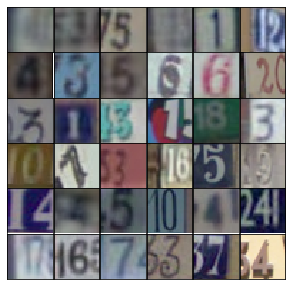

In [6]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

Here we need to do a bit of preprocessing and getting the images into a form where we can pass batches to the network. First off, we need to rescale the images to a range of -1 to 1, since the output of our generator is also in that range. We also have a set of test and validation images which could be used if we're trying to identify the numbers in the images.

In [7]:
def scale(x, feature_range=(-1, 1)): # tanh
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range (-1, 1)
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [8]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(self.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x), y

## Network Inputs

Here, just creating some placeholders like normal.

In [9]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    return inputs_real, inputs_z

## Generator

Here you'll build the generator network. The input will be our noise vector `z` as before. Also as before, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our SVHN images.

What's new here is we'll use convolutional layers to create our new images. The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x1024 as in the original DCGAN paper. Then we use batch normalization and a leaky ReLU activation. Next is a transposed convolution where typically you'd halve the depth and double the width and height of the previous layer. Again, we use batch normalization and leaky ReLU. For each of these layers, the general scheme is convolution > batch norm > leaky ReLU.

You keep stacking layers up like this until you get the final transposed convolution layer with shape 32x32x3. Below is the archicture used in the original DCGAN paper:

![DCGAN Generator](assets/dcgan.png)

Note that the final layer here is 64x64x3, while for our SVHN dataset, we only want it to be 32x32x3.

In [10]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x = tf.layers.dense(z, 4*4*512)
        h1 = tf.reshape(x, (-1, 4, 4, 512))
        bn1 = tf.layers.batch_normalization(h1, training=training)
        nl1 = tf.maximum(alpha * bn1, bn1)
        # 4x4x512 now
        
        h2 = tf.layers.conv2d_transpose(nl1, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(h2, training=training)
        nl2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x256 now
        
        h3 = tf.layers.conv2d_transpose(nl2, 128, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(h3, training=training)
        nl3 = tf.maximum(alpha * bn3, bn3)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(nl3, output_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
        # 32x32x3 now
        
        return out

## Discriminator

Here you'll build the discriminator. This is basically just a convolutional classifier like you've build before. The input to the discriminator are 32x32x3 tensors/images. You'll want a few convolutional layers, then a fully connected layer for the output. As before, we want a sigmoid output, and you'll need to return the logits as well. For the depths of the convolutional layers I suggest starting with 16, 32, 64 filters in the first layer, then double the depth as you add layers. Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpool layers.

You'll also want to use batch normalization with `tf.layers.batch_normalization` on each layer except the first convolutional and output layers. Again, each layer should look something like convolution > batch norm > leaky ReLU. 

Note: in this project, your batch normalization layers will always use batch statistics. (That is, always set `training` to `True`.) That's because we are only interested in using the discriminator to help train the generator. However, if you wanted to use the discriminator for inference later, then you would need to set the `training` parameter appropriately.

In [11]:
def discriminator(x, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        h1 = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
        bn1 = tf.layers.batch_normalization(h1, training=training)
        nl1 = tf.maximum(alpha * bn1, bn1)
        # 16x16x64
        
        h2 = tf.layers.conv2d(nl1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(h2, training=training)
        nl2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        h3 = tf.layers.conv2d(nl2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(h3, training=training)
        nl3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        h4_flat = tf.reshape(nl3, (-1, 4*4*256))
        logits = tf.layers.dense(h4_flat, 1)
        return logits

## Model Loss

Calculating the loss like before, nothing new here.

In [12]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    input_gen = generator(input_z, output_dim, alpha=alpha)
    Q = discriminator(input_real, alpha=alpha)
    Q_ = discriminator(input_gen, alpha=alpha, reuse=True)
    loss = tf.reduce_mean(Q-Q_) 
    return loss

## Optimizers

Not much new here, but notice how the train operations are wrapped in a `with tf.control_dependencies` block so the batch normalization layers can update their population statistics.

In [13]:
def model_opt(loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(-loss, var_list=g_vars)

    return d_train_opt, g_train_opt

## Building the model

Here we can use the functions we defined about to build the model as a class. This will make it easier to move the network around in our code since the nodes and operations in the graph are packaged in one object.

In [14]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        self.input_real, self.input_z = model_inputs(real_dim=real_size, z_dim=z_size)
        
        self.loss = model_loss(input_real=self.input_real, input_z=self.input_z, output_dim=real_size[2], 
                               alpha=alpha)
        
        self.d_opt, self.g_opt = model_opt(loss=self.loss, learning_rate=learning_rate, beta1=beta1)

Here is a function for displaying generated images.

In [15]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

And another function we can use to train our network. Notice when we call `generator` to create the samples to display, we set `training` to `False`. That's so the batch normalization layers will use the population statistics rather than the batch statistics. Also notice that we set the `net.input_real` placeholder when we run the generator's optimizer. The generator doesn't actually use it, but we'd get an error without it because of the `tf.control_dependencies` block we created in `model_opt`. 

In [16]:
def train(net, dataset, epochs, batch_size, print_every=10, show_every=100, figsize=(5,5)):
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x, y in dataset.batches(batch_size):

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
                
                if len(x) != batch_size:
                    print(batch_z.shape, x.shape)
                    
                else:
                    # Run optimizers
                    loss, _, _ = sess.run([net.loss, net.d_opt, net.g_opt], feed_dict={net.input_real: x, 
                                                                                       net.input_z: batch_z})
                    steps += 1
                    if steps % print_every == 0:
                        print("Epoch {}/{}...".format(e+1, epochs),
                              "Dloss: {:.4f}".format(loss),
                              "Gloss: {:.4f}".format(-loss))
                        # Save losses to view after training
                        losses.append((loss, -loss))

                    if steps % show_every == 0:
                        gen_samples = sess.run(
                                       generator(net.input_z, 3, reuse=True, training=False),
                                       feed_dict={net.input_z: sample_z})
                        samples.append(gen_samples)
                        _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                        plt.show()

        # saver.save(sess, './checkpoints/generator.ckpt')
        # with open('samples.pkl', 'wb') as f:
        #     pkl.dump(samples, f)
    
    return losses, samples

## Hyperparameters

GANs are very sensitive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other. Try out your own hyperparameters or read [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) to see what worked for them.

In [17]:
real_size = (32,32,3)
z_size = 100
learning_rate = 0.0002
batch_size = 128
epochs = 100
alpha = 0.2
beta1 = 0.5

tf.reset_default_graph()

# Create the network
net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

dataset = Dataset(trainset, testset)

Epoch 1/100... Dloss: -5.3090 Gloss: 5.3090
Epoch 1/100... Dloss: -25.3845 Gloss: 25.3845
Epoch 1/100... Dloss: -40.8360 Gloss: 40.8360
Epoch 1/100... Dloss: -68.3900 Gloss: 68.3900
Epoch 1/100... Dloss: -81.9577 Gloss: 81.9577
Epoch 1/100... Dloss: -111.3702 Gloss: 111.3702
Epoch 1/100... Dloss: -107.5606 Gloss: 107.5606
Epoch 1/100... Dloss: -115.3186 Gloss: 115.3186
Epoch 1/100... Dloss: -121.6497 Gloss: 121.6497
Epoch 1/100... Dloss: -72.3433 Gloss: 72.3433


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/matplotlib/axes/_base.py:1334: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


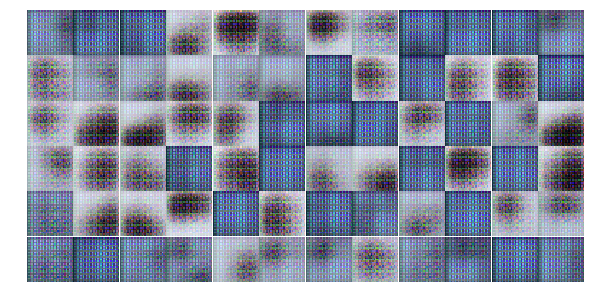

Epoch 1/100... Dloss: -115.2942 Gloss: 115.2942
Epoch 1/100... Dloss: -127.7621 Gloss: 127.7621
Epoch 1/100... Dloss: -129.3329 Gloss: 129.3329
Epoch 1/100... Dloss: -161.5944 Gloss: 161.5944
Epoch 1/100... Dloss: -148.9308 Gloss: 148.9308
Epoch 1/100... Dloss: -165.2455 Gloss: 165.2455
Epoch 1/100... Dloss: -170.6490 Gloss: 170.6490
Epoch 1/100... Dloss: -177.5395 Gloss: 177.5395
Epoch 1/100... Dloss: -213.2977 Gloss: 213.2977
Epoch 1/100... Dloss: -219.2848 Gloss: 219.2848


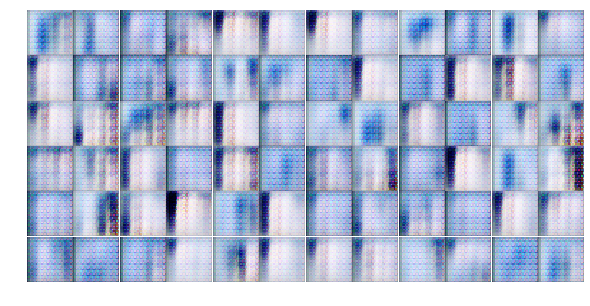

Epoch 1/100... Dloss: -239.9316 Gloss: 239.9316
Epoch 1/100... Dloss: -197.4918 Gloss: 197.4918
Epoch 1/100... Dloss: -231.1448 Gloss: 231.1448
Epoch 1/100... Dloss: -226.2967 Gloss: 226.2967
Epoch 1/100... Dloss: -235.2534 Gloss: 235.2534
Epoch 1/100... Dloss: -221.4058 Gloss: 221.4058
Epoch 1/100... Dloss: -259.6603 Gloss: 259.6603
Epoch 1/100... Dloss: -257.8056 Gloss: 257.8056
Epoch 1/100... Dloss: -277.6776 Gloss: 277.6776
Epoch 1/100... Dloss: -245.5475 Gloss: 245.5475


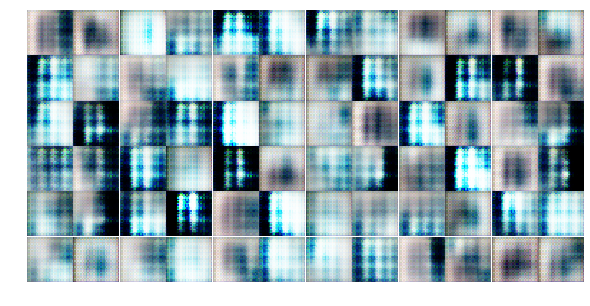

Epoch 1/100... Dloss: -233.5567 Gloss: 233.5567
Epoch 1/100... Dloss: -320.8629 Gloss: 320.8629
Epoch 1/100... Dloss: -282.5659 Gloss: 282.5659
Epoch 1/100... Dloss: -242.4839 Gloss: 242.4839
Epoch 1/100... Dloss: -266.7591 Gloss: 266.7591
Epoch 1/100... Dloss: -312.2855 Gloss: 312.2855
Epoch 1/100... Dloss: -194.8658 Gloss: 194.8658
Epoch 1/100... Dloss: -202.6549 Gloss: 202.6549
Epoch 1/100... Dloss: -33.3512 Gloss: 33.3512
Epoch 1/100... Dloss: -253.1542 Gloss: 253.1542


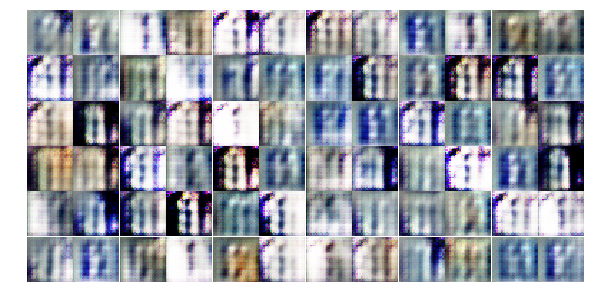

Epoch 1/100... Dloss: -244.3178 Gloss: 244.3178
Epoch 1/100... Dloss: -268.5839 Gloss: 268.5839
Epoch 1/100... Dloss: -101.1111 Gloss: 101.1111
Epoch 1/100... Dloss: -206.0597 Gloss: 206.0597
Epoch 1/100... Dloss: -178.1201 Gloss: 178.1201
Epoch 1/100... Dloss: -266.3941 Gloss: 266.3941
Epoch 1/100... Dloss: -44.0502 Gloss: 44.0502
Epoch 1/100... Dloss: -149.7140 Gloss: 149.7140
Epoch 1/100... Dloss: -204.4945 Gloss: 204.4945
Epoch 1/100... Dloss: -356.9952 Gloss: 356.9952


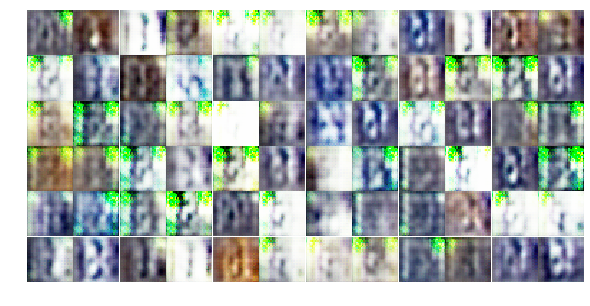

Epoch 1/100... Dloss: -480.9850 Gloss: 480.9850
Epoch 1/100... Dloss: -303.0202 Gloss: 303.0202
Epoch 1/100... Dloss: -412.8684 Gloss: 412.8684
Epoch 1/100... Dloss: -455.1673 Gloss: 455.1673
Epoch 1/100... Dloss: -241.9071 Gloss: 241.9071
Epoch 1/100... Dloss: -376.3939 Gloss: 376.3939
Epoch 1/100... Dloss: -97.8187 Gloss: 97.8187
(128, 100) (41, 32, 32, 3)
Epoch 2/100... Dloss: -303.2924 Gloss: 303.2924
Epoch 2/100... Dloss: -342.8857 Gloss: 342.8857
Epoch 2/100... Dloss: -315.0293 Gloss: 315.0293


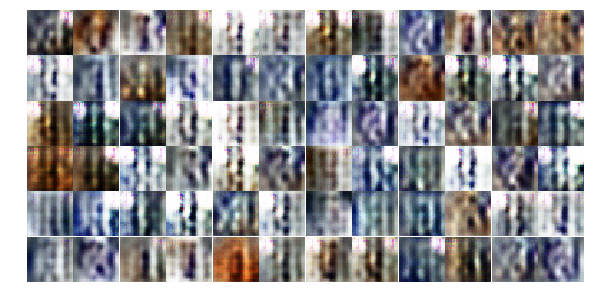

Epoch 2/100... Dloss: -159.9986 Gloss: 159.9986
Epoch 2/100... Dloss: -341.0593 Gloss: 341.0593
Epoch 2/100... Dloss: -480.2830 Gloss: 480.2830
Epoch 2/100... Dloss: -198.9393 Gloss: 198.9393
Epoch 2/100... Dloss: -381.3520 Gloss: 381.3520
Epoch 2/100... Dloss: -391.9208 Gloss: 391.9208
Epoch 2/100... Dloss: -558.2914 Gloss: 558.2914
Epoch 2/100... Dloss: -63.9489 Gloss: 63.9489
Epoch 2/100... Dloss: -216.6248 Gloss: 216.6248
Epoch 2/100... Dloss: -386.3828 Gloss: 386.3828


In [ ]:
losses, samples = train(net=net, dataset=dataset, epochs=epochs, batch_size=batch_size, figsize=(10,5))

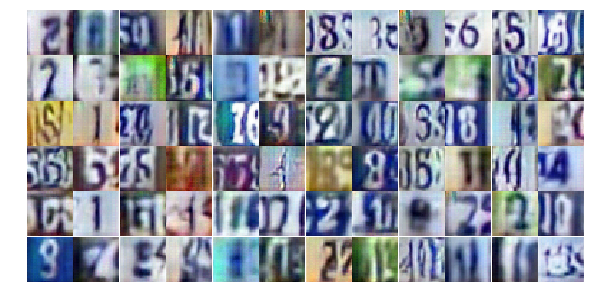
### Epoch 83/100... Dloss: 2926.0657 Gloss: -1177.2257

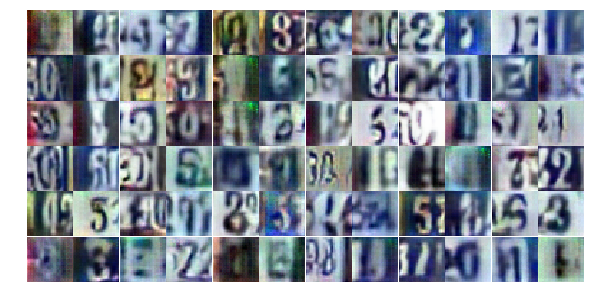
# Epoch 48/100... Dloss: 420.6616 Gloss: 724.4807
# Epoch 48/100... Dloss: 879.9136 Gloss: -176.1049
# Epoch 48/100... Dloss: -1791.0081 Gloss: 3932.7676
# Epoch 48/100... Dloss: -2801.4778 Gloss: 6863.1729

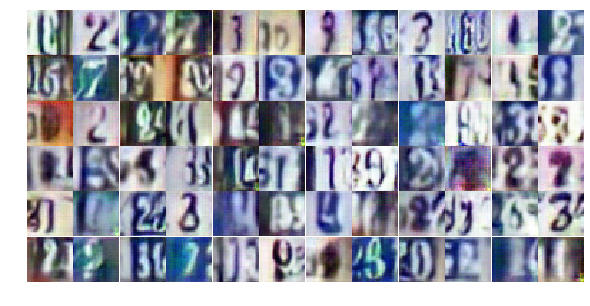
# Epoch 52/100... Dloss: -1472.1127 Gloss: 3138.7900
# Epoch 52/100... Dloss: 4493.6494 Gloss: -1275.7036
# Epoch 52/100... Dloss: -1469.9209 Gloss: 2364.3931
# Epoch 52/100... Dloss: -2147.6304 Gloss: 2832.8071

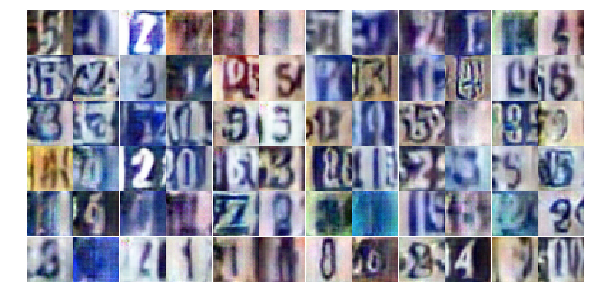

# Epoch 43/100... Dloss: 396.3466 Gloss: -260.8196
# Epoch 43/100... Dloss: -1380.1530 Gloss: 1556.8933

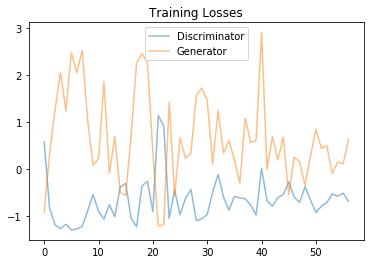

In [22]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

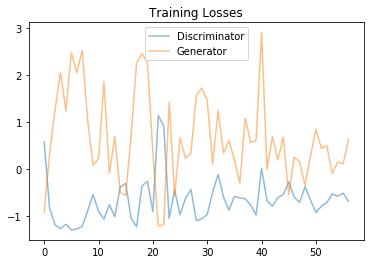

In [23]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


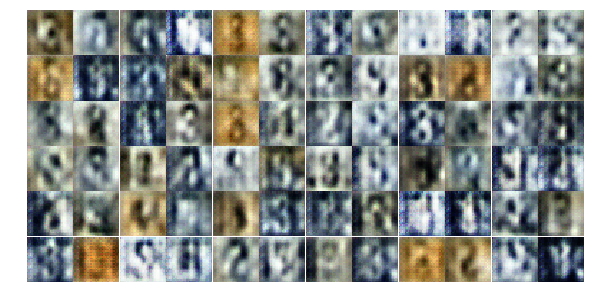

In [24]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))

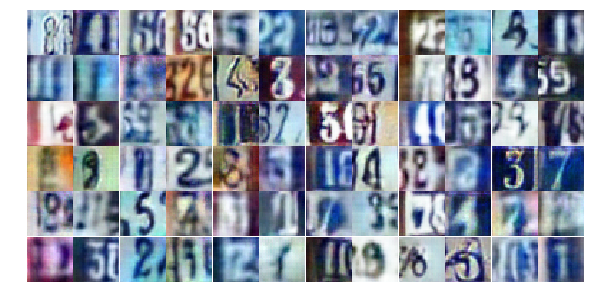

In [19]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))